In [1]:
import sys 
sys.path.append('..')
import alpenglow.files as af
import matplotlib.pyplot as plt
%matplotlib inline
import skimage.external.tifffile as tiff
from skimage import transform
import numpy as np
import shutil as sh
import os
import boto3
from scipy import optimize
import alpenglow.stitching
from imp import reload
reload(alpenglow.stitching)
from alpenglow.stitching import stitch

In [2]:
from skimage.feature import register_translation
from skimage import img_as_float
from skimage import exposure

### Importing data 

In [3]:
s3 = boto3.resource('s3')

bucket = s3.Bucket('alpenglowoptics')

ll = list(bucket.objects.all())


In [4]:
af.download_s3('76AO/Strips/im_000005_000019.tif', '../data/im_000005_000019.tif')

In [5]:
af.download_s3('76AO/Strips/im_000006_000019.tif', '../data/im_000006_000019.tif')

In [6]:
af.download_s3('76AO/Strips/im_000007_000019.tif', '../data/im_000007_000019.tif')

In [7]:
af.download_s3('76AO/Strips/im_000008_000019.tif', '../data/im_000008_000019.tif')

In [8]:
af.download_s3('76AO/Strips/im_000009_000019.tif', '../data/im_000009_000019.tif')

In [9]:
af.download_s3('76AO/Strips/im_000010_000019.tif', '../data/im_000010_000019.tif')

In [10]:
im_5_19 = tiff.imread("../data/im_000005_000019.tif")

In [11]:
im_6_19 = tiff.imread("../data/im_000006_000019.tif")

In [12]:
im_7_19 = tiff.imread("../data/im_000007_000019.tif")

In [13]:
im_8_19 = tiff.imread("../data/im_000008_000019.tif")

In [14]:
im_9_19 = tiff.imread("../data/im_000009_000019.tif")

In [15]:
im_10_19 = tiff.imread("../data/im_000010_000019.tif")

In [10]:
im_5_19.shape
#good shape

(900, 23872)

### Visual inspection 

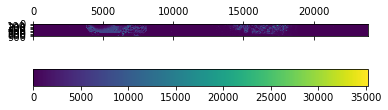

In [11]:
figure,axis = plt.subplots(1)
im_5 = axis.matshow(im_5_19)
figure.colorbar(im_5, orientation="horizontal")


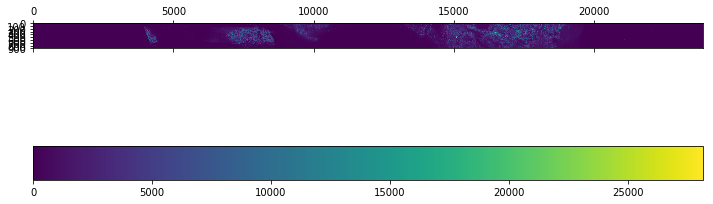

In [12]:
figure,axis = plt.subplots(1)
im_6 = axis.matshow(im_6_19)
plt.colorbar(im_6, orientation="horizontal")
figure.set_size_inches([12,12])

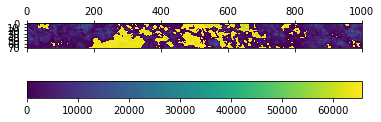

In [13]:
figure,axis = plt.subplots(1)
im = axis.matshow(im_5_19[:75,17000:18000] - im_6_19[825:,17000:18000])
plt.colorbar(im, orientation="horizontal")
#subtracting to see difference. Actually not a good idea because of strip-strip intensity difference

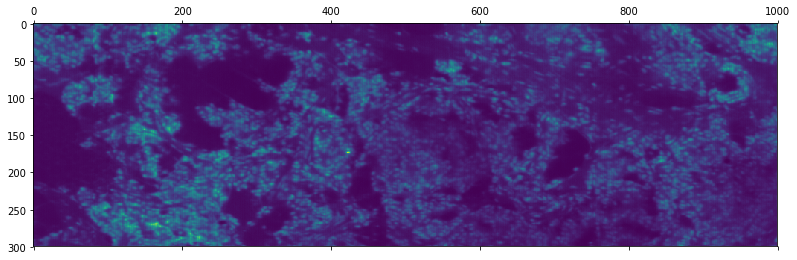

In [14]:
plt.matshow(im_5_19[:300,17000:18000])

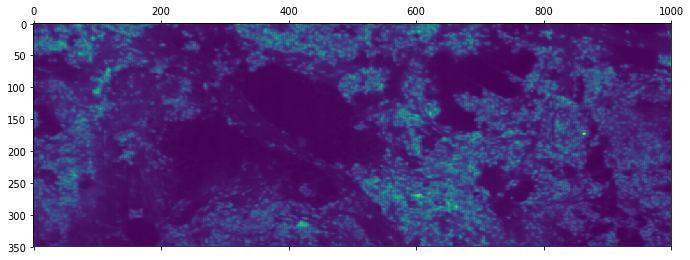

In [15]:
plt.matshow(im_5_19[:350,(17000-440):(18000-440)])

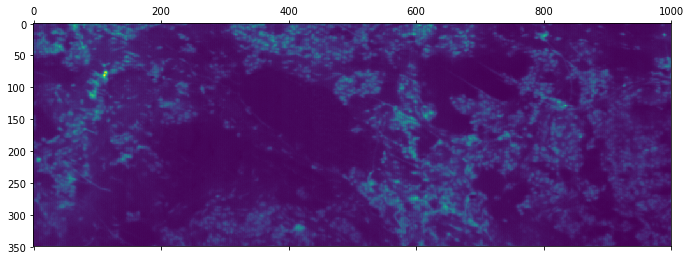

In [16]:
plt.matshow(im_6_19[550:,17000:18000])

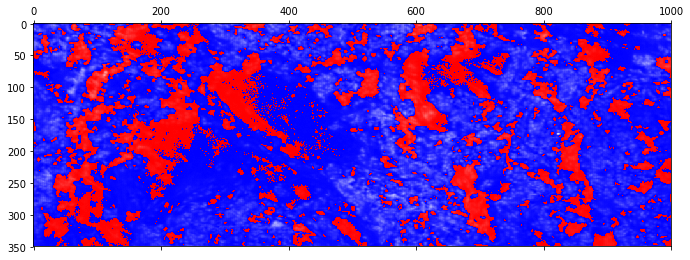

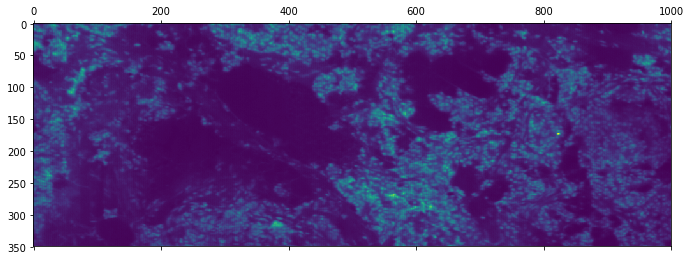

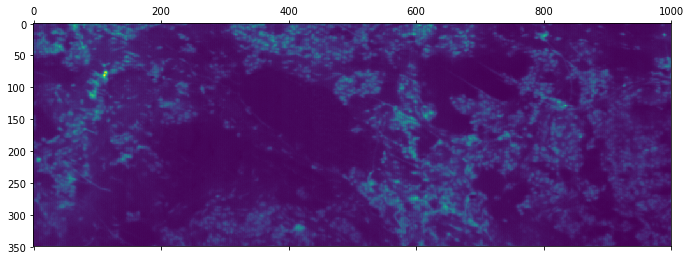

In [17]:
def jigger(x,y,stripOne, stripTwo):
    plt.matshow(stripOne[:x,(17000-y):(18000-y)] - stripTwo[900-x:,17000:18000], cmap='bwr')
    plt.matshow(stripOne[:x,(17000-y):(18000-y)])
    plt.matshow(stripTwo[900- x:,17000:18000])
jigger(350, 400, im_5_19, im_6_19)

### Looking for the sweet spot 

In [18]:
empty_set=np.zeros([201,201]) #first create an empty set of the correct size
xs = np.linspace(100,700,201).astype(int) #take 201 numbers from 100 to 700
ys = np.linspace(100,700,201).astype(int) #need to say its an integer
for i in range(len(xs)):
    x = xs[i]
    for j in range(len(ys)):
        y = ys[j]
        empty_set[i,j] = np.corrcoef(np.ravel(im_5_19[:x,(17000-y):(18000-y)]), np.ravel(im_6_19[900-x:,17000:18000]))[0,1]
        
    

KeyboardInterrupt: 

In [ ]:
plt.matshow(empty_set)

In [ ]:
np.max(empty_set) #max correlation coefficient for empty_set

In [ ]:
np.where(empty_set == np.max(empty_set)) #what are the coordinates of the max?

In [ ]:
jigger(xs[82], ys[111], im_5_19, im_6_19) #show a plot of the diff between im_5 and im_6 at those coords

In [ ]:
xs[82] #what is the actual value? How close is it to our guess of 350?

In [ ]:
xs

In [ ]:
ys[111] # what is the actual value? how close is it to our guess of 440?

Now we need to use a smaller step size = 1 around the range near [346,433]

In [ ]:
xs = np.arange(340,360,1).astype(int)
ys = np.arange(430,460,1).astype(int)
empty_set=np.zeros([xs.shape[0],ys.shape[0]])
for i in range(len(xs)):
    x = xs[i]
    for j in range(len(ys)):
        y = ys[j]
        empty_set[i,j] = np.corrcoef(np.ravel(im_5_19[:x,(17000-y):(18000-y)]), np.ravel(im_6_19[900-x:,17000:18000]))[0,1]
        

In [ ]:
plt.matshow(empty_set)

In [ ]:
np.where(empty_set == np.max(empty_set))

In [ ]:
xs[5]

In [ ]:
ys[4]

### Now we need to test with im_7

In [ ]:
jigger(345, 434, im_6_19, im_7_19)

In [ ]:
xs = np.array([345]) #take 201 numbers from 100 to 700
ys = np.linspace(-5000,5000,501).astype(int) #need to say its an integer
empty_set=np.zeros([xs.shape[0],ys.shape[0]]) #create a set of the correct size to contain correlations
for i in range(len(xs)):
    x = xs[i]
    for j in range(len(ys)):
        y = ys[j]
        empty_set[i,j] = np.corrcoef(np.ravel(im_6_19[:x,(10000-y):(15000-y)]), np.ravel(im_7_19[900-x:,10000:15000]))[0,1]
        
    

In [ ]:
plt.plot(empty_set.T)

In [ ]:
np.where(empty_set == np.nanmax(empty_set))

In [ ]:
np.nanmax(empty_set)

In [ ]:
ys[228]

### Method 2: The minimization function

In [ ]:
def diff_squared(image1, image2):
    rmse = np.sqrt(np.mean((image1 - image2)**2))
    return rmse

In [ ]:
def err_func(params, image1, image2):
    x, y = params
    x = int(x*image1.shape[0])
    y = int(y*image1.shape[1])
    if y>0:
        a = image1[:x,:image1.shape[1]-y]
        b = image2[image2.shape[0]-x:,y:]
    else:
        a = image1[:x,-y:]
        b = image2[image2.shape[0]-x:,:image2.shape[1]+y]
    rmse = np.sqrt(np.mean((a - b)**2))
    return rmse
err_func([345,-120], im_6_19, im_7_19)

In [ ]:
def test(image1, image2, x, y):
    if y>0:
        a = image1[:x,:image1.shape[1]-y]
        b = image2[image2.shape[0]-x:,y:]
    else:
        a = image1[:x,-y:]
        b = image2[image2.shape[0]-x:,:image2.shape[1]+y]
    return a, b
a, b = test(im_6_19, im_7_19, 345, -120)
a.shape, b.shape

In [ ]:
optimize.minimize(err_func, [0.3,0.0], args=(im_6_19, im_7_19))

### Fourier transform

In [19]:
image1=im_6_19
image2=im_7_19

In [20]:
cols1 = image1.shape[1]
cols2 = image2.shape[1]
rows1 = image1.shape[0]
rows2 = image2.shape[0]
shift, error, diffphase = register_translation(image1[:rows1//2, int(cols1//2-0.1*cols1):int(cols1//2+0.1*cols1)],
                                               image2[rows2//2:, int(cols2//2-0.1*cols2):int(cols2//2+0.1*cols2)])

In [21]:
shift, error, diffphase
# we found our algorithm

(array([-104.,  441.]), 0.77960516007097913, 1.0185204874026082e-15)

In [22]:
overlap=rows1//2+shift[0]
overlap

346.0

### Next step: stitching after we know offsets 

In [ ]:
offset = transform.SimilarityTransform(translation=(overlap, -shift[1]))
no_offset = transform.SimilarityTransform(translation=(0, 0))

In [ ]:
image1_transformed = transform.warp(image1, inverse_map=offset, output_shape=((2*rows1-overlap), (2*cols1-cols1-shift[1])))
image2_transformed = transform.warp(image2, inverse_map=no_offset, output_shape=((2*rows2-overlap), (2*cols2-cols2-shift[1])))

In [ ]:
image1_transformed.shape

In [ ]:
plt.matshow(image1_transformed[:,15000:16000])
plt.matshow(image2_transformed[:,15000:16000])

In [ ]:
mask = (image1_transformed != 0) & (image2_transformed != 0)
registered = image1_transformed + image2_transformed
registered[mask] /= 2

In [ ]:
plt.matshow(registered[:,15000:16000])
plt.matshow(image1[:,15000:16000])
plt.matshow(image2[:,15000:16000])

In [23]:
import alpenglow.stitching

In [24]:
stitched = alpenglow.stitching.stitch(im_6_19, im_7_19)

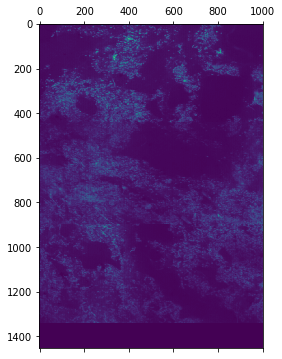

In [25]:
plt.matshow(stitched[:,15000:16000])

### Histogram normalization

In [37]:
np.max(im_6_19)

28145

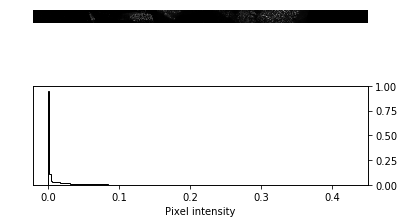

In [36]:

figure, axes = plt.subplots(2)
def plot_img_and_hist(img, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    img = img_as_float(img)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(img, cmap=plt.cm.gray)
    ax_img.set_axis_off()
    ax_img.set_adjustable('box-forced')

    # Display histogram
    ax_hist.hist(img.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    # ax_hist.set_xlim(0, 1) 
    ax_hist.set_yticks([])
    
plot_img_and_hist(im_6_19, axes, bins=256)

In [ ]:
# contrast stretching
p2, p98 = np.percentile(im_6_19, (2, 98))
im_6_19_rescale = exposure.rescale_intensity(im_6_19, in_range=(p2, p98))
plt.matshow(im_6_19[:,15000:16000])
plt.matshow(im_6_19_rescale[:,15000:16000])

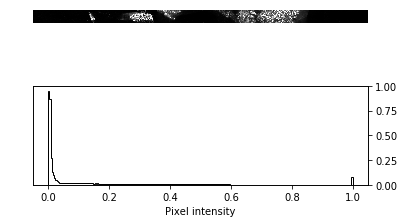

In [39]:
figure, axes = plt.subplots(2)
plot_img_and_hist(im_6_19_rescale, axes, bins=256)

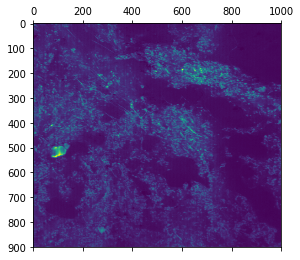

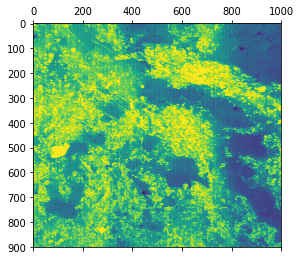

In [41]:
# histogram equalization
im_6_19_eq = exposure.equalize_hist(im_6_19)
plt.matshow(im_6_19[:,15000:16000])
plt.matshow(im_6_19_eq[:,15000:16000])

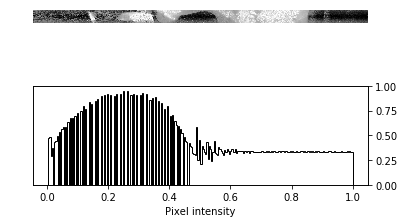

In [42]:
figure, axes = plt.subplots(2)
plot_img_and_hist(im_6_19_eq, axes, bins=256)

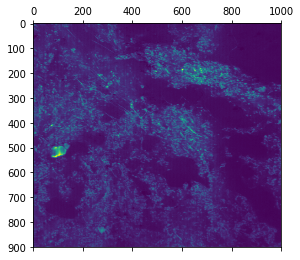

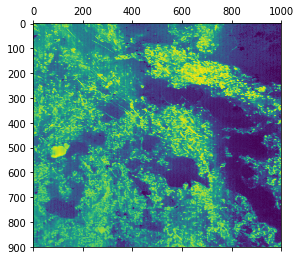

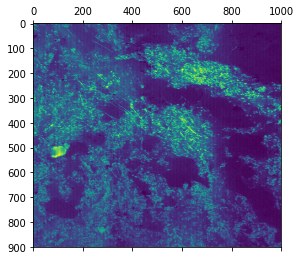

In [49]:
# adaptive equalization
im_6_19_adapteq = exposure.equalize_adapthist(im_6_19, clip_limit=0.0)
im_6_19_adapteq1 = exposure.equalize_adapthist(im_6_19, clip_limit=0.01) #this one looks better
plt.matshow(im_6_19[:,15000:16000])
plt.matshow(im_6_19_adapteq[:,15000:16000])
plt.matshow(im_6_19_adapteq1[:,15000:16000])

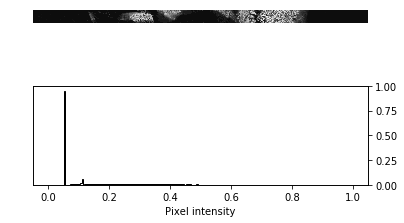

In [48]:
figure, axes = plt.subplots(2)
plot_img_and_hist(im_6_19_adapteq, axes, bins=256)

#### Applying histogram equalization, then stitching

In [178]:
im_8_19_adapteq = exposure.equalize_adapthist(im_8_19, clip_limit=0.01)
im_9_19_adapteq = exposure.equalize_adapthist(im_9_19, clip_limit=0.01)

In [179]:
stitch_im_8_9_19, shift = stitch(im_8_19_adapteq, im_9_19_adapteq)

../alpenglow/stitching.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  registered = np.zeros((rows1 + rows2 - overlap, cols1))
../alpenglow/stitching.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  registered[rows2:, :cols1-shift[1]] = image1[overlap:, shift[1]:]


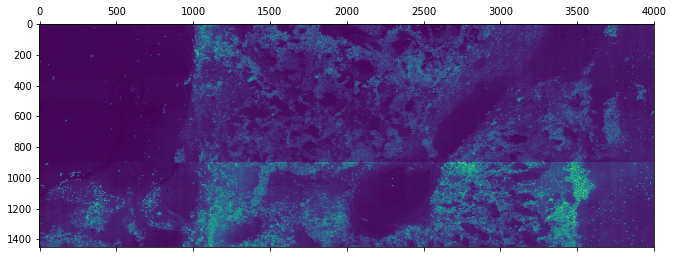

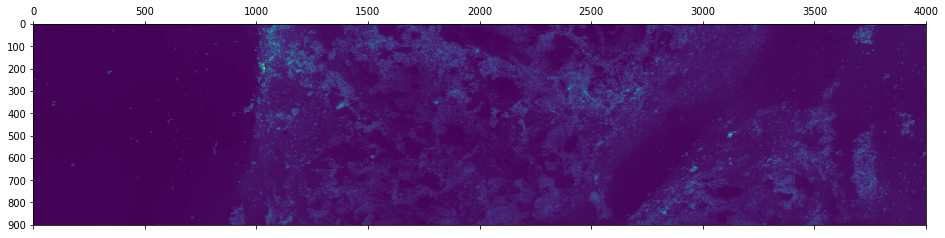

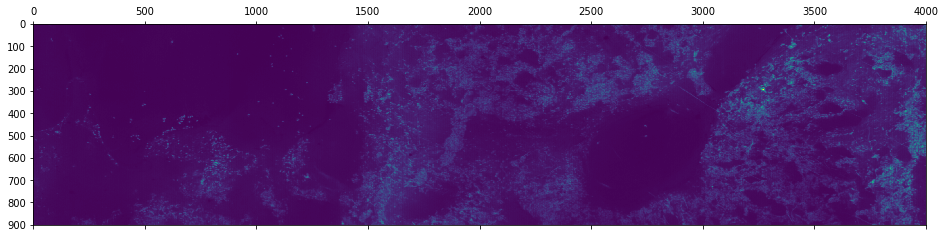

In [180]:
plt.matshow(stitch_im_8_9_19[:,15000:19000])
plt.matshow(im_9_19[:,15000:19000])
plt.matshow(im_8_19[:,15000:19000])

In [16]:
stitch_im_7_8_19, shift = stitch(im_7_19, im_8_19)

../alpenglow/stitching.py:70: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  registered = np.zeros((rows1 + rows2 - overlap, cols1), dtype=int)
../alpenglow/stitching.py:75: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  registered[rows2-margin:, abs(shift[1]):] = image1[overlap-margin:, :shift[1]]
../alpenglow/stitching.py:83: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  fade1[:, abs(shift[1]):] = image1[overlap-margin:overlap, :shift[1]] * np.arange(0, 1, 0.01)[:, np.newaxis]


In [17]:
stitch_im_7_8_19_adapteq = exposure.equalize_adapthist(stitch_im_7_8_19, clip_limit=0.01)

/opt/anaconda/lib/python3.5/site-packages/skimage/util/dtype.py:106: UserWarning: Possible sign loss when converting negative image of type int64 to positive image of type uint16.
  "%s to positive image of type %s." % (dtypeobj_in, dtypeobj))
/opt/anaconda/lib/python3.5/site-packages/skimage/util/dtype.py:136: UserWarning: Downcasting int64 to uint16 without scaling because max value 40120 fits in uint16
  warn(msg)


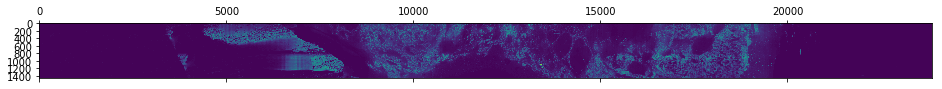

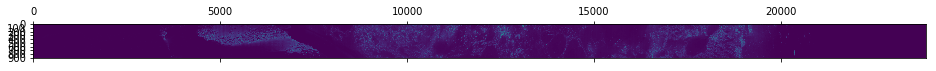

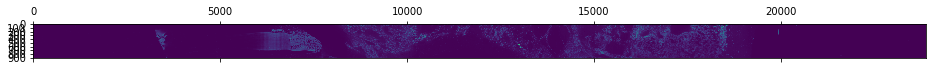

In [18]:
plt.matshow(stitch_im_7_8_19_adapteq)
plt.matshow(im_8_19)
plt.matshow(im_7_19)

In [226]:
stitch_im_7_8_9_19, shift = stitch(stitch_im_7_8_19_adapteq, im_9_19)

../alpenglow/stitching.py:70: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  registered = np.zeros((rows1 + rows2 - overlap, cols1), dtype=int)
../alpenglow/stitching.py:73: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  registered[rows2:, :cols1-shift[1]] = image1[overlap:, shift[1]:]


In [227]:
debug

> /opt/anaconda/lib/python3.5/site-packages/skimage/feature/register_translation.py(156)register_translation()
    154     # images must be the same shape
    155     if src_image.shape != target_image.shape:
--> 156         raise ValueError("Error: images must be same size for "
    157                          "register_translation")
    158 

ipdb> shift
*** NameError: name 'shift' is not defined
ipdb> q


In [224]:
stitch_im_7_8_9_19_adapteq = exposure.equalize_adapthist(stitch_im_7_8_9_19, clip_limit=0.01)

/opt/anaconda/lib/python3.5/site-packages/skimage/util/dtype.py:106: UserWarning: Possible sign loss when converting negative image of type int64 to positive image of type uint16.
  "%s to positive image of type %s." % (dtypeobj_in, dtypeobj))
/opt/anaconda/lib/python3.5/site-packages/skimage/util/dtype.py:136: UserWarning: Downcasting int64 to uint16 without scaling because max value 49595 fits in uint16
  warn(msg)


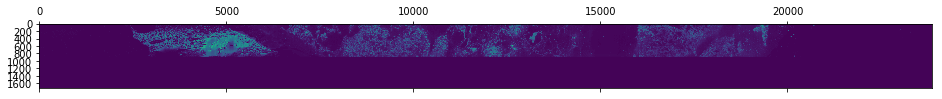

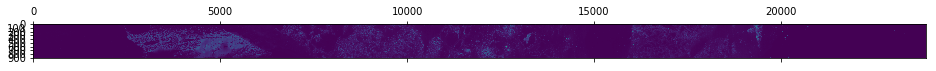

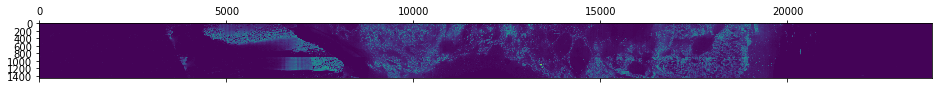

In [225]:
plt.matshow(stitch_im_7_8_9_19_adapteq)
plt.matshow(im_9_19)
plt.matshow(stitch_im_7_8_19_adapteq)

In [218]:
reload(alpenglow.stitching)
from alpenglow.stitching import stitch

In [19]:
def find_shift(image1, image2):
    """ 
    Identify lateral shifts to stitch two images
    
    Parameters
    ----------
    image1, image2 : 2D arrays
        The images to be stitched, *in order* (bottom, top)

    Returns
    -------
    tuple : lateral shifts (x, y)
    """
    
    cols1 = image1.shape[1]
    cols2 = image2.shape[1]
    rows1 = image1.shape[0]
    rows2 = image2.shape[0]
    resized_image1 = np.zeros((rows1 + (rows2-rows1), cols1), dtype=int)
    resized_image1 = image1
    shift, error, diffphase = register_translation(resized_image1[:rows2//2, int(cols2//2-0.1*cols2):int(cols2//2+0.1*cols2)],
                                                   image2[rows2//2:, int(cols2//2-0.1*cols2):int(cols2//2+0.1*cols2)])
    return shift

In [20]:
find_shift(stitch_im_7_8_19_adapteq, im_9_19)

array([-103.,  445.])

In [25]:
def apply_shift(image1, image2, shift, margin=100):
    """ 
    Apply a lateral shift between two images, stitching them together
    
    Parameters
    ----------
    image1, image2 : 2D arrays
        The images to be stitched, *in order* (bottom, top)
    
    shift : sequence of length 2 
        x, y lateral shifts
    
    Returns
    -------
    Stitched image
    
    """
    
    cols1 = image1.shape[1]
    cols2 = image2.shape[1]
    rows1 = image1.shape[0]
    rows2 = image2.shape[0]

    overlap=rows2 // 2 + shift[0]
    registered = np.zeros((rows1 + rows2 - overlap, cols1), dtype=int)
    registered[:rows2-margin] = image2[:rows2-margin]
    if shift[1] > 0:
        registered[rows2-margin:, :cols1-shift[1]] = image1[overlap-margin:, shift[1]:] 
    else:
        registered[rows2-margin:, abs(shift[1]):] = image1[overlap-margin:, :shift[1]] 
    
    if margin > 0:
        fade2 = image2[rows2 - margin:rows2] * np.arange(1, 0, -0.01)[:, np.newaxis]
        fade1 = np.zeros_like(fade2)
        if shift[1] > 0:
            fade1[:, :cols1-shift[1]] = image1[overlap-margin:overlap, shift[1]:] * np.arange(0, 1, 0.01)[:, np.newaxis]
        else:
            fade1[:, abs(shift[1]):] = image1[overlap-margin:overlap, :shift[1]] * np.arange(0, 1, 0.01)[:, np.newaxis]

        registered[rows2 - margin:rows2] = fade1 + fade2

    return registered.astype(int)


In [29]:
stitch_im_7_8_9_19 = apply_shift(stitch_im_7_8_19, im_9_19, shift)

/opt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:25: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/opt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:30: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/opt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:38: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [30]:
stitch_im_7_8_9_19_adapteq = exposure.equalize_adapthist(stitch_im_7_8_9_19, clip_limit=0.01)

/opt/anaconda/lib/python3.5/site-packages/skimage/util/dtype.py:106: UserWarning: Possible sign loss when converting negative image of type int64 to positive image of type uint16.
  "%s to positive image of type %s." % (dtypeobj_in, dtypeobj))
/opt/anaconda/lib/python3.5/site-packages/skimage/util/dtype.py:136: UserWarning: Downcasting int64 to uint16 without scaling because max value 49595 fits in uint16
  warn(msg)


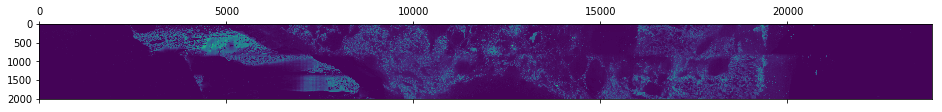

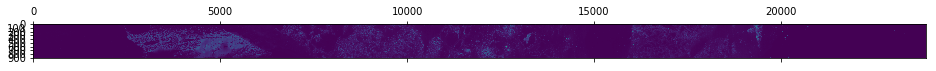

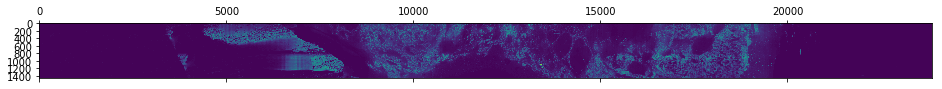

In [31]:
plt.matshow(stitch_im_7_8_9_19_adapteq)
plt.matshow(im_9_19)
plt.matshow(stitch_im_7_8_19_adapteq)